## Configurar Spark

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit

# --- Configuración Spark (4GB) ---
os.environ['SPARK_HOME'] = "/home/hadoop/spark"
sys.path.insert(0, "/home/hadoop/spark/python")
sys.path.insert(0, "/home/hadoop/spark/python/lib/py4j-0.10.9.7-src.zip")
sys.path.insert(0, "/home/hadoop/spark/python/lib/pyspark.zip")

spark = SparkSession.builder \
    .appName("EDA_Trafico_Mini") \
    .master("yarn") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "2") \
    .config("spark.yarn.executor.memoryOverhead", "1024m") \
    .getOrCreate()

# Cargar tu dataset balanceado (El "Mini")
PATH_MINI = "/trafico_train_mini"
print(f"📂 Cargando dataset balanceado desde: {PATH_MINI}")
df = spark.read.parquet(PATH_MINI)


25/11/25 13:49:39 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.
25/11/25 13:49:39 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/25 13:49:40 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.
25/11/25 13:49:40 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'sp

📂 Cargando dataset balanceado desde: /trafico_train_mini


In [3]:
print("⬇️  Extrayendo muestra de 50000")
df_plot = df.sample(fraction=0.1, seed=42).limit(50000).toPandas()
print(f"✅ Muestra lista en memoria: {df_plot.shape}")

⬇️  Extrayendo muestra de 50000


25/11/25 13:51:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

✅ Muestra lista en memoria: (50000, 63)


## Distribución de variable onjetivo


Distribución de clases


                       Label     count  porcentaje
0                     Benign  13425831   83.012717
1           DDOS attack-HOIC    686012    4.241653
2     DDoS attacks-LOIC-HTTP    576191    3.562623
3           DoS attacks-Hulk    461912    2.856030
4                        Bot    286191    1.769536
5             FTP-BruteForce    193354    1.195519
6             SSH-Bruteforce    187589    1.159874
7              Infilteration    161096    0.996066
8   DoS attacks-SlowHTTPTest    139890    0.864948
9      DoS attacks-GoldenEye     41508    0.256646
10     DoS attacks-Slowloris     10990    0.067952
11      DDOS attack-LOIC-UDP      1730    0.010697
12          Brute Force -Web       611    0.003778
13          Brute Force -XSS       230    0.001422
14             SQL Injection        87    0.000538


/tmp/ipykernel_296049/2793885469.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="Label", data=distribucion, palette="plasma")


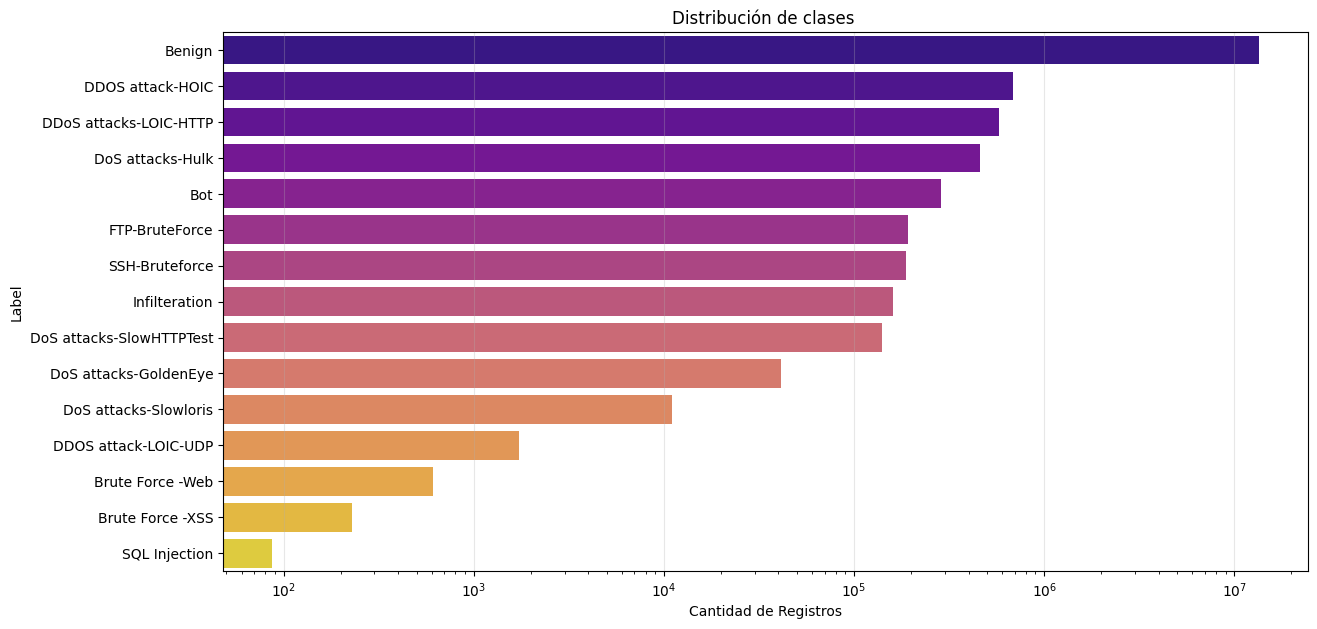

In [4]:
print("\nDistribución de clases")

distribucion = df.groupBy("Label").count().orderBy("count", ascending=False).toPandas()

total = distribucion["count"].sum()
distribucion["porcentaje"] = (distribucion["count"] / total) * 100

print(distribucion)

# Gráfica
plt.figure(figsize=(14, 7))
sns.barplot(x="count", y="Label", data=distribucion, palette="plasma")
plt.title("Distribución de clases ")
plt.xlabel("Cantidad de Registros")
plt.xscale("log") 
plt.grid(axis="x", alpha=0.3)
plt.show()

## Correlación y redundancia

Generando Mapa de Calor.


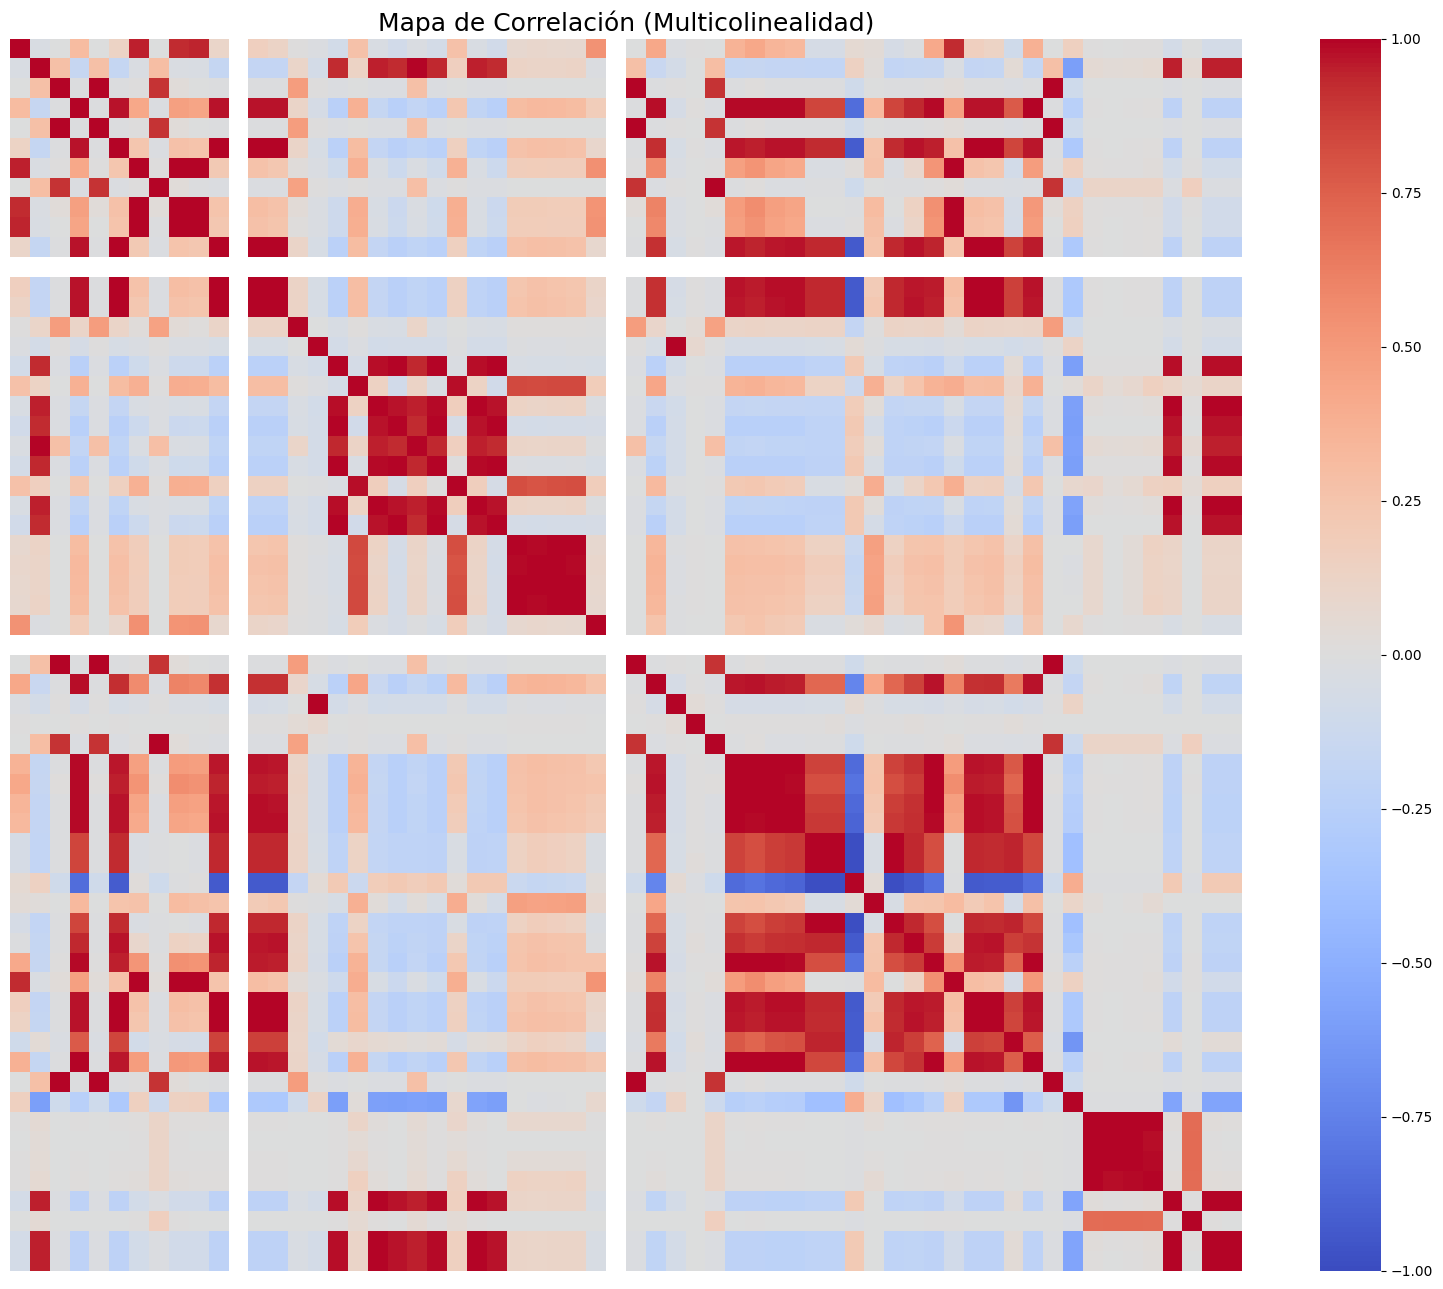

🔍 Variables altamente correlacionadas (> 0.95):
Flow Duration  Fwd IAT Tot          0.999560
Tot Fwd Pkts   TotLen Fwd Pkts      1.000000
               Fwd Header Len       1.000000
               Fwd Act Data Pkts    1.000000
Tot Bwd Pkts   TotLen Bwd Pkts      0.976072
               Bwd Pkt Len Max      0.970525
               Bwd Pkt Len Mean     0.974018
               Bwd Pkt Len Std      0.971001
               Bwd Header Len       0.980074
               Pkt Len Max          0.991819
dtype: float64


In [4]:

print("Generando Mapa de Calor.")

# Seleccionar solo columnas numéricas (excluyendo Label)
cols_numericas = [c for c in df_plot.columns if c != "Label"]

# Calculamos correlación
corr_matrix = df_plot[cols_numericas].corr()

# Graficamos
plt.figure(figsize=(20, 16))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    vmin=-1, vmax=1,
    square=True,
    xticklabels=False, yticklabels=False # Ocultamos etiquetas si son muchas para limpieza visual
)
plt.title("Mapa de Correlación (Multicolinealidad)", fontsize=18)
plt.show()

# Reporte textual de redundancia
print("🔍 Variables altamente correlacionadas (> 0.95):")
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
pares_altos = upper.stack()
redundantes = pares_altos[pares_altos.abs() > 0.95]
print(redundantes.head(10)) # Muestra las primeras 10

Generando Boxplots de Separabilidad...


/tmp/ipykernel_308523/1551767999.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Clase", y=var, data=df_plot, palette="Set2")
/tmp/ipykernel_308523/1551767999.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Clase", y=var, data=df_plot, palette="Set2")
/tmp/ipykernel_308523/1551767999.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Clase", y=var, data=df_plot, palette="Set2")
/tmp/ipykernel_308523/1551767999.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. 

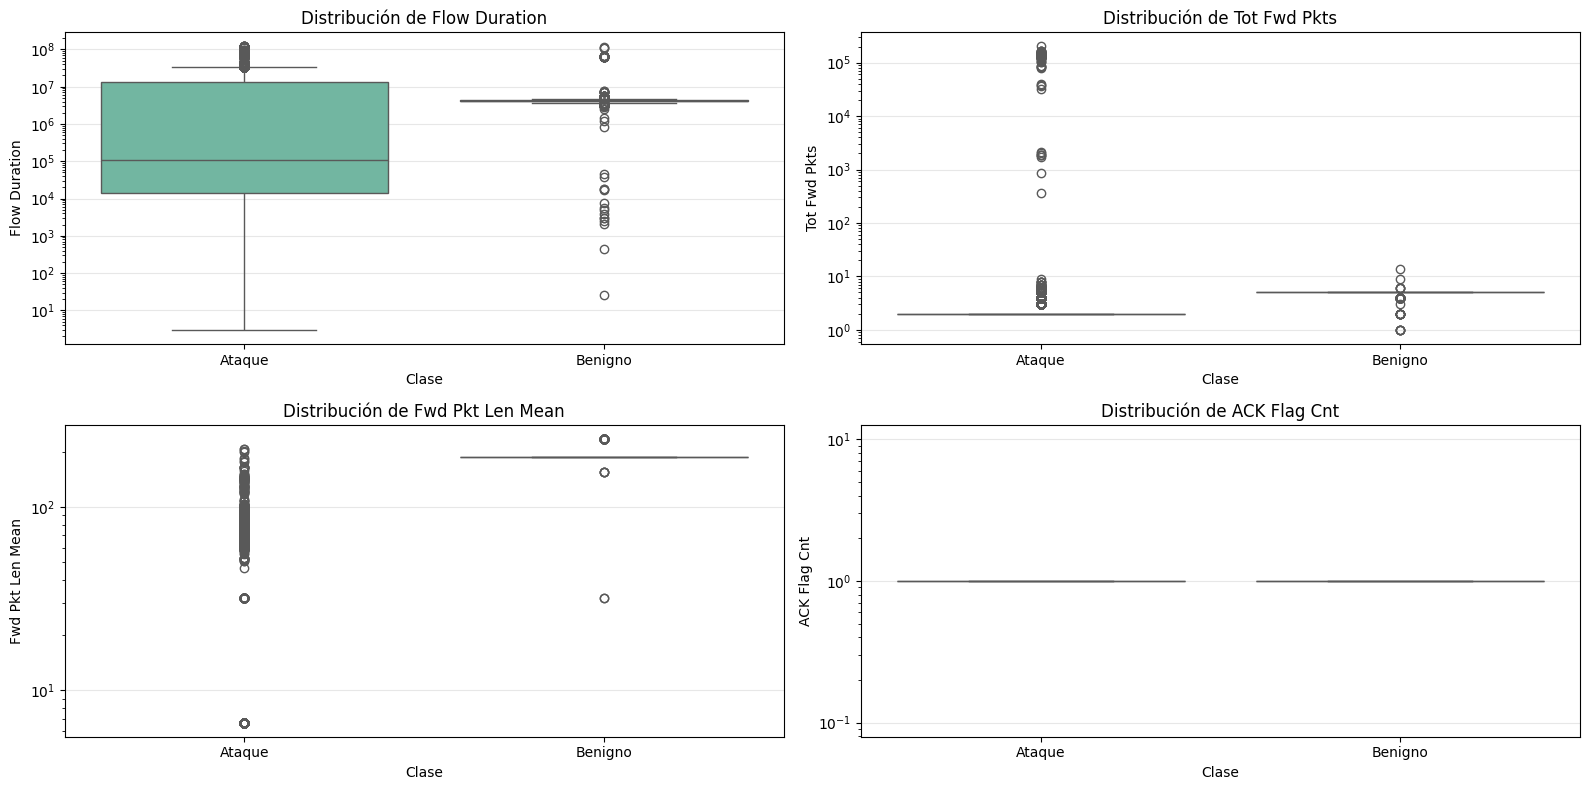

In [5]:
# --- PREGUNTA 2: SEPARABILIDAD (Benigno vs Ataque) ---
print("Generando Boxplots de Separabilidad...")

# Crear columna binaria temporal para la gráfica
df_plot["Clase"] = df_plot["Label"].apply(lambda x: "Benigno" if x == "Benign" else "Ataque")

# Variables clave a analizar
vars_interes = ["Flow Duration", "Tot Fwd Pkts", "Fwd Pkt Len Mean", "ACK Flag Cnt"]

plt.figure(figsize=(16, 8))
for i, var in enumerate(vars_interes):
    if var in df_plot.columns:
        plt.subplot(2, 2, i+1)
        # Usamos escala logarítmica porque los ataques suelen tener valores extremos
        sns.boxplot(x="Clase", y=var, data=df_plot, palette="Set2")
        plt.yscale("log")
        plt.title(f"Distribución de {var}")
        plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

📈 Analizando potencial de variables...


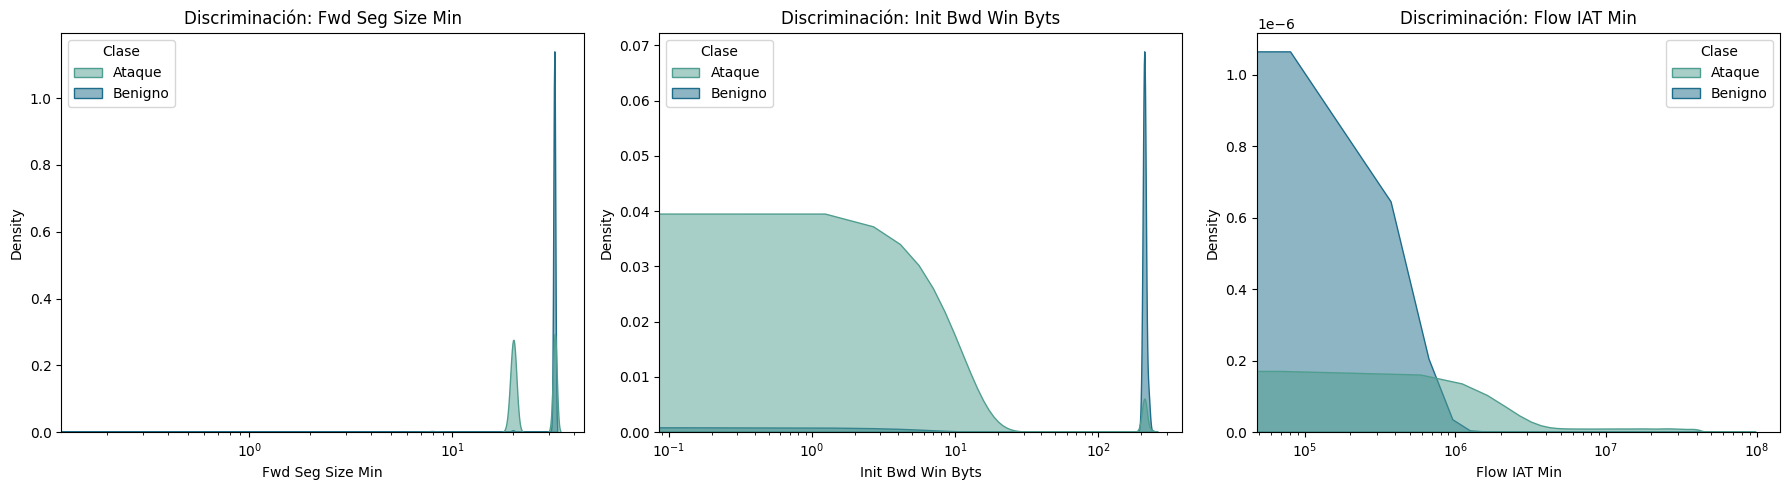

In [6]:
# --- PREGUNTA 4: POTENCIAL DISCRIMINATORIO (Histogramas) ---
print("📈 Analizando potencial de variables...")

# Variables candidatas a ser importantes
vars_potenciales = ["Fwd Seg Size Min", "Init Bwd Win Byts", "Flow IAT Min"]

plt.figure(figsize=(18, 5))

for i, var in enumerate(vars_potenciales):
    if var in df_plot.columns:
        plt.subplot(1, 3, i+1)
        # Histograma (KDE) por clase
        sns.kdeplot(data=df_plot, x=var, hue="Clase", fill=True, common_norm=False, palette="crest", alpha=0.5)
        plt.xscale("log") # Log para ver mejor los datos
        plt.title(f"Discriminación: {var}")

plt.tight_layout()
plt.show()

## Resultados de Random Forest

📂 Cargando el modelo guardado...


25/11/25 00:38:16 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.
25/11/25 00:38:17 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.
25/11/25 00:38:22 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.
25/11/25 00:38:23 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.
25/11/25 00:38:26 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead'

✅ Modelo cargado exitosamente.

🏆 TOP 20 VARIABLES MÁS IMPORTANTES:
              Columna  Importancia
57   Fwd Seg Size Min     0.100235
54  Init Fwd Win Byts     0.091755
0            Dst Port     0.077004
51   Subflow Fwd Byts     0.036925
31     Fwd Header Len     0.036179
18       Flow IAT Max     0.035310
33         Fwd Pkts/s     0.035279
6     Fwd Pkt Len Max     0.034388
15        Flow Pkts/s     0.032536
4     TotLen Fwd Pkts     0.032499
19       Flow IAT Min     0.030307
16      Flow IAT Mean     0.030227
24        Fwd IAT Min     0.028579
21       Fwd IAT Mean     0.026594
20        Fwd IAT Tot     0.026489
1       Flow Duration     0.024491
23        Fwd IAT Max     0.020865
48   Fwd Seg Size Avg     0.017907
8    Fwd Pkt Len Mean     0.015684
55  Init Bwd Win Byts     0.013538


/tmp/ipykernel_293134/173023618.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Columna', data=df_importancia.head(20), palette='viridis')


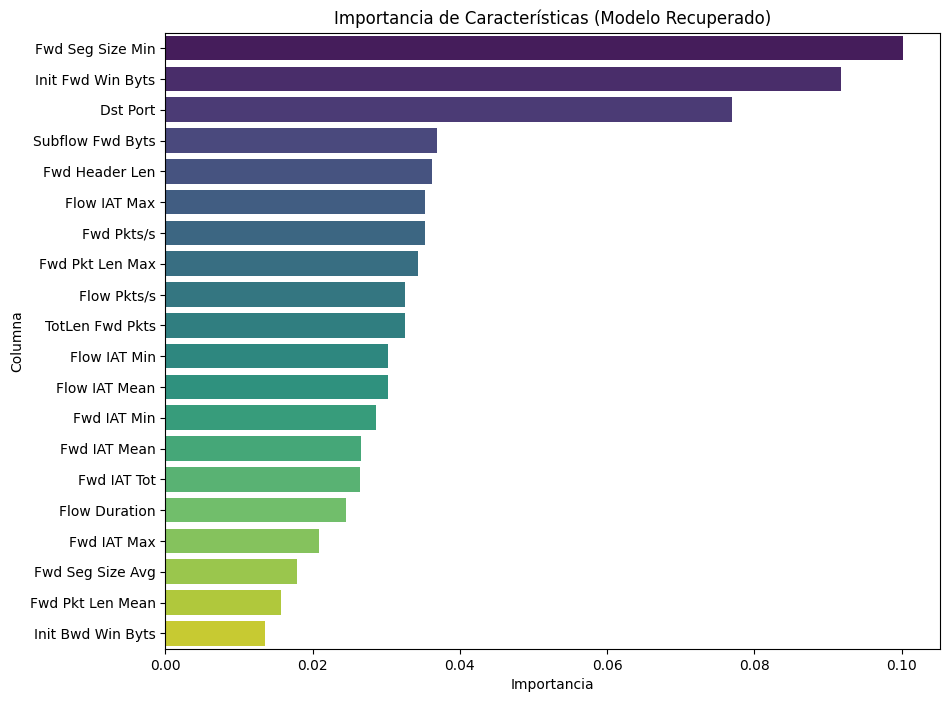

In [4]:
import pandas as pd
from pyspark.ml import PipelineModel

print("📂 Cargando el modelo guardado...")
ruta_modelo = "/modelos/rf_all_features_v1"

# 1. Cargar el Pipeline completo (que incluye los 4 stages que viste)
model_cargado = PipelineModel.load(ruta_modelo)

# 2. Identificar los Stages (Etapas)
# Según tu 'ls', el orden es:
# 0: StringIndexer
# 1: VectorAssembler (Aquí están los nombres de las columnas originales)
# 2: StandardScaler
# 3: RandomForestClassifier (Aquí están los valores de importancia)

assembler_stage = model_cargado.stages[1] # VectorAssembler
rf_stage = model_cargado.stages[-1]       # RandomForest (el último)

print("✅ Modelo cargado exitosamente.")

# 3. Extraer los Nombres de las Columnas
# El VectorAssembler guarda qué columnas usó como entrada
nombres_columnas = assembler_stage.getInputCols()

# 4. Extraer los Valores de Importancia
# El RandomForest tiene el atributo 'featureImportances'
importancias = rf_stage.featureImportances.toArray()

# 5. Unir Nombres con Valores y Ordenar
df_importancia = pd.DataFrame({
    'Columna': nombres_columnas,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# 6. Mostrar el Top 20
print("\n🏆 TOP 20 VARIABLES MÁS IMPORTANTES:")
print(df_importancia.head(20))

# Opcional: Graficar
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.barplot(x='Importancia', y='Columna', data=df_importancia.head(20), palette='viridis')
plt.title('Importancia de Características (Modelo Recuperado)')
plt.show()